<a href="https://colab.research.google.com/github/PeterSpitz/cap-comp215/blob/main/comp_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Comp 215 Project 1

Peter Spitz

Joubin Eghbali

In [4]:
#imports for graphs
import matplotlib
import matplotlib.pyplot as plt
import datetime, json, requests, math
from pprint import pprint    # Pretty Print - built-in python function to nicely format data structures

In [5]:
#must have valid inputs
START_DATE = "2026-01-01" #yyyy-mm-dd returns one week of data
UPPER_DATE = "2040-01-01" #upper and lower are the window for the time period to be examined.
LOWER_DATE = "2020-01-01" #Do not make window too large or the graph will become unreadable

#can be set to None if unwanted
ASTEROID_ID = None #int. set to None to skip search
ASTEROID_NAME = None #str. set to None to skip search
#if name and id are both set, but point to different asteroids the search will fail
DANGEROUS = True #bool. any value other than True/False skips search
ORBITING_BODY = "Earth" #str. set to None to skip search

In [6]:
API_KEY = 'S896m0XG5ds8v5gN97Gsa8Fh8YrnXrIpPEoqnkPF'

def get_neos(start_date):

    url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={start_date}&api_key={API_KEY}'

    response = requests.get(url)
    data = response.json()

    return [neo for dated_records in data['near_earth_objects'].values() for neo in dated_records]

def get_neo(id):
    """ Return a NEO record for the given id """
    url = f'https://api.nasa.gov/neo/rest/v1/neo/{id}?api_key={API_KEY}'
    response = requests.request("GET", url, headers={}, data={})
    return json.loads(response.text)

neos = get_neos(START_DATE)
print(f'{len(neos)} Near Earth Objects found for week of {START_DATE}')
assert len(neos) > 0, f'Oh oh!  No NEOs found for {START_DATE}'
neo = get_neo(neos[-1]['id'])  # get the very latest NEO
#print(len(neo['close_approach_data']))
pprint(neos[-1])

142 Near Earth Objects found for week of 2026-01-01
{'absolute_magnitude_h': 26.351,
 'close_approach_data': [{'close_approach_date': '2026-01-01',
                          'close_approach_date_full': '2026-Jan-01 01:43',
                          'epoch_date_close_approach': 1767231780000,
                          'miss_distance': {'astronomical': '0.0575834242',
                                            'kilometers': '8614357.607626454',
                                            'lunar': '22.3999520138',
                                            'miles': '5352713.6087509052'},
                          'orbiting_body': 'Earth',
                          'relative_velocity': {'kilometers_per_hour': '39942.4199108548',
                                                'kilometers_per_second': '11.0951166419',
                                                'miles_per_hour': '24818.6664162753'}}],
 'estimated_diameter': {'feet': {'estimated_diameter_max': 104.6706762414,
         

In [7]:
class CloseApproach:
  '''stores desired data from a single object'''

  def __init__(self, orbiting_body:str, approach_date:datetime, miss_distance:float, velocity:float):
    self.orbiting_body = orbiting_body
    self.approach_date = approach_date
    self.miss_distance = miss_distance
    self.velocity = velocity

  def __str__(self):
    return f"Object will approach {self.orbiting_body} on {self.approach_date} traveling {self.velocity}km/hr at a distance of {self.miss_distance}km"


In [8]:
def get_close_approach(record):
  '''processes data from single neo record into a closeapproach object'''

  return CloseApproach(
    record['orbiting_body'],
    datetime.datetime.strptime(record['close_approach_date_full'], "%Y-%b-%d %H:%M"), #converts string into datetime object
    float(record['miss_distance']['kilometers']),
    float(record['relative_velocity']['kilometers_per_hour'])
  )


In [9]:
class Asteroid:
  '''stores data for a single asteroid'''

  def __init__(self, id:int, name:str, d_min = 0.0, d_max = 0.0, hazard = None, close:list = []) -> None:
    self.id = id
    self.name = name
    self.d_min = d_min
    self.d_max = d_max
    self.hazard = hazard
    self.close = close #list of nearby objects

  def __str__(self) -> str:
    return f"Asteroid:{self.name}\nid:{self.id}\ndiameter:{self.d_min}-{self.d_max}\nhazardous:{self.hazard}\nnumber of close approaches: {len(self.close)}"

  def nearest_miss(self) -> CloseApproach:
    '''find the closest miss'''
    test = sorted(self.close, key=lambda CloseApproach: CloseApproach.miss_distance)
    return test[0]


In [10]:
def name_search(temp_neo,neo_name):
  if neo_name == None:
    return temp_neo

  for i in range(len(temp_neo)):
    if temp_neo[i]["name"] == neo_name:
      return [temp_neo[i]]

  return []

In [11]:
def id_search(temp_neo,neo_id):
  if neo_id == None:
    return temp_neo

  for i in range(len(temp_neo)):
    if int(temp_neo[i]["id"]) == neo_id:
      return [temp_neo[i]]

  return []

In [12]:
def danger_search(temp_neo,danger):
  if danger == True:
    return [x for x in temp_neo if x["is_potentially_hazardous_asteroid"] == True]
  elif danger == False:
    return [x for x in temp_neo if x["is_potentially_hazardous_asteroid"] == False]
  else:
    return temp_neo

In [13]:
def search_close(temp_neo,orbit):
  #filter by orbiting body
  if orbit == None:
    close = [get_close_approach(x) for x in temp_neo['close_approach_data']]
  else:
    #can fail to find any match resulting in an empty list.
    close = [get_close_approach(x) for x in temp_neo['close_approach_data'] if x['orbiting_body'] == orbit]

  #filter data to a set period of time.
  close = [x for x in close if x.approach_date < datetime.datetime.strptime(UPPER_DATE, "%Y-%m-%d")
                           and x.approach_date > datetime.datetime.strptime(LOWER_DATE, "%Y-%m-%d")]

  return close

In [14]:
def asteroids_from_neo(neo_id:int, neo_name:str, orbit:str, danger:bool):
  '''creates a list of asteroid objects from search parameters'''

  #list of neos. Always assume more than one result from search
  temp_neo = get_neos(START_DATE)

  #filter by name
  temp_neo = name_search(temp_neo, neo_name)

  #filter by id
  temp_neo = id_search(temp_neo, neo_id)

  #filter by dangerous
  temp_neo = danger_search(temp_neo,danger)

  #end search if search failed to find neo
  if temp_neo == None or len(temp_neo) == 0:
    return None

  #update neos with full close approach list
  for i in range(len(temp_neo)):
    temp_neo[i] = get_neo(neos[i]['id'])

  #remove required data
  close = [search_close(x,orbit) for x in temp_neo]
  result = zip(temp_neo,close)

  result = [Asteroid(a["id"], a['name'], close = b) for a,b in result if len(b) > 0]

  #check if close search had any valid results
  if len(result) > 0:
    return result
  else:
    return None


In [15]:
def draw_graph(asteroids):

    import matplotlib.dates as mdates
    from matplotlib.ticker import FuncFormatter

    plt.style.use("seaborn-v0_8-darkgrid")  # professional style
    plt.figure(figsize=(14, 7))

    for asteroid in asteroids:

        x = [approach.approach_date for approach in asteroid.close]
        y = [approach.miss_distance for approach in asteroid.close]

        plt.plot(
            x,
            y,
            marker='o',
            linewidth=2.5,
            markersize=6,
            label=asteroid.name
        )

    ax = plt.gca()

    # Format date axis
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    # Format y-axis with commas
    ax.yaxis.set_major_formatter(
        FuncFormatter(lambda x, p: format(int(x), ","))
    )

    plt.title("Near Earth Object Close Approaches (2020–2040)",
              fontsize=16, fontweight='bold')
    plt.xlabel("Close Approach Year", fontsize=12)
    plt.ylabel("Miss Distance (km)", fontsize=12)

    plt.legend(title="Asteroids", fontsize=10, title_fontsize=11)
    plt.tight_layout()
    plt.show()

In [16]:
def closest_approach(asteroid_list):

    # --- ERROR CHECK ---
    if asteroid_list is None or len(asteroid_list) == 0:
        print("No asteroids found in selected search range.")
        return

    results = []   # store (asteroid, closest_approach)

    for asteroid in asteroid_list:

        if len(asteroid.close) == 0:
            continue

        closest = asteroid.nearest_miss()
        results.append((asteroid, closest))

    if len(results) == 0:
        print("No valid close approach data found.")
        return

    # Sort by miss distance (smallest first)
    results.sort(key=lambda x: x[1].miss_distance)

    print("===== TOP 3 CLOSEST OBJECTS =====")

    top_n = min(3, len(results))  # if less than 3, handle safely

    for i in range(top_n):
        asteroid, approach = results[i]
        print(f"{i+1}. Asteroid: {asteroid.name}")
        print(f"   Distance (km): {approach.miss_distance:,.2f}")
        print(f"   Date: {approach.approach_date}")
        print()

searched 142 asteroids
found 8 matches


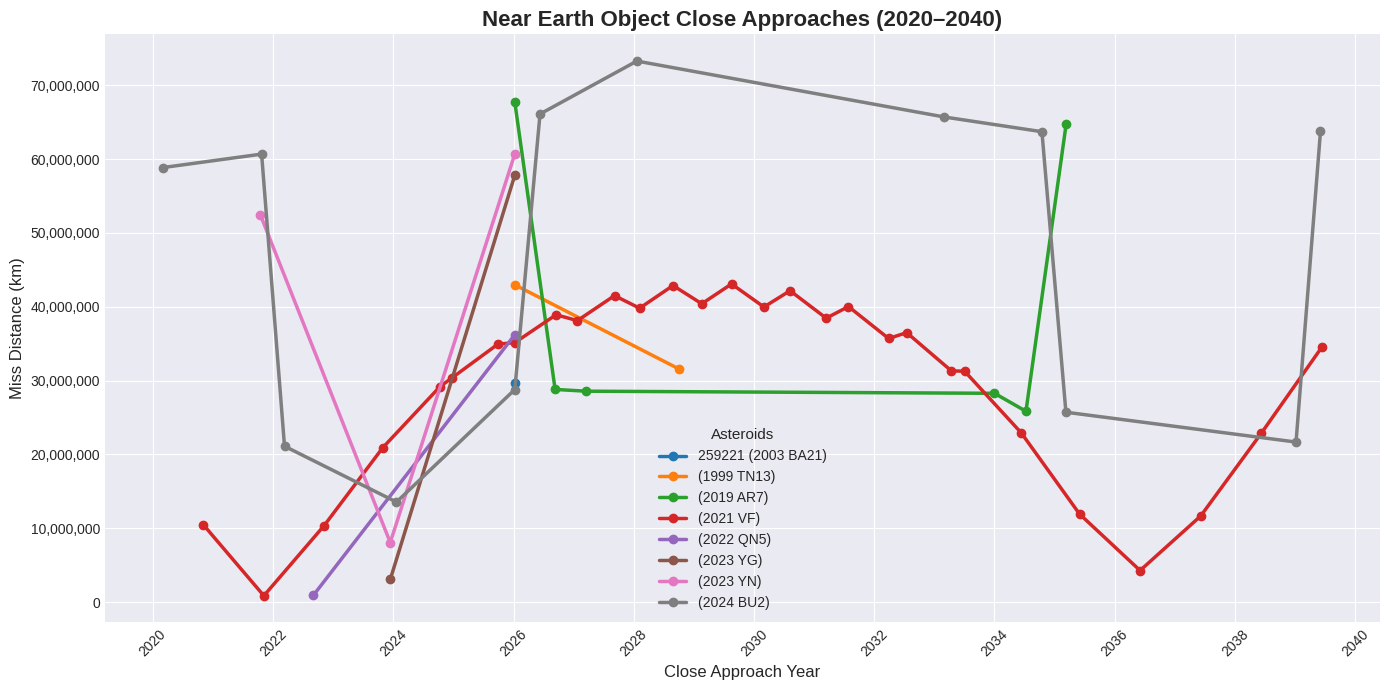

===== TOP 3 CLOSEST OBJECTS =====
1. Asteroid: (2021 VF)
   Distance (km): 863,685.34
   Date: 2021-11-05 12:27:00

2. Asteroid: (2022 QN5)
   Distance (km): 935,649.48
   Date: 2022-09-02 16:46:00

3. Asteroid: (2023 YG)
   Distance (km): 3,081,715.25
   Date: 2023-12-13 17:27:00



In [17]:
def main():
  asteroid_list = asteroids_from_neo(ASTEROID_ID, ASTEROID_NAME, ORBITING_BODY, DANGEROUS)

  if asteroid_list == None:
    print(f"searched {len(neos)} asteroids\nfound 0 matches")
  else:
    print(f"searched {len(neos)} asteroids\nfound {len(asteroid_list)} matches")

    draw_graph(asteroid_list)
    closest_approach(asteroid_list)

main()